# GRU

RNN存在的问题：梯度较容易出现衰减或爆炸（BPTT）  
⻔控循环神经⽹络：捕捉时间序列中时间步距离较⼤的依赖关系  
**RNN**:  


![Image Name](https://cdn.kesci.com/upload/image/q5jjvcykud.png?imageView2/0/w/320/h/320)


$$
H_{t} = ϕ(X_{t}W_{xh} + H_{t-1}W_{hh} + b_{h})
$$
**GRU**:


![Image Name](https://cdn.kesci.com/upload/image/q5jk0q9suq.png?imageView2/0/w/640/h/640)



$$
R_{t} = σ(X_tW_{xr} + H_{t−1}W_{hr} + b_r)\\    
Z_{t} = σ(X_tW_{xz} + H_{t−1}W_{hz} + b_z)\\  
\widetilde{H}_t = tanh(X_tW_{xh} + (R_t ⊙H_{t−1})W_{hh} + b_h)\\
H_t = Z_t⊙H_{t−1} + (1−Z_t)⊙\widetilde{H}_t
$$
• 重置⻔有助于捕捉时间序列⾥短期的依赖关系；  
• 更新⻔有助于捕捉时间序列⾥⻓期的依赖关系。    
### 载入数据集
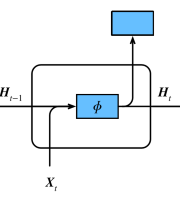
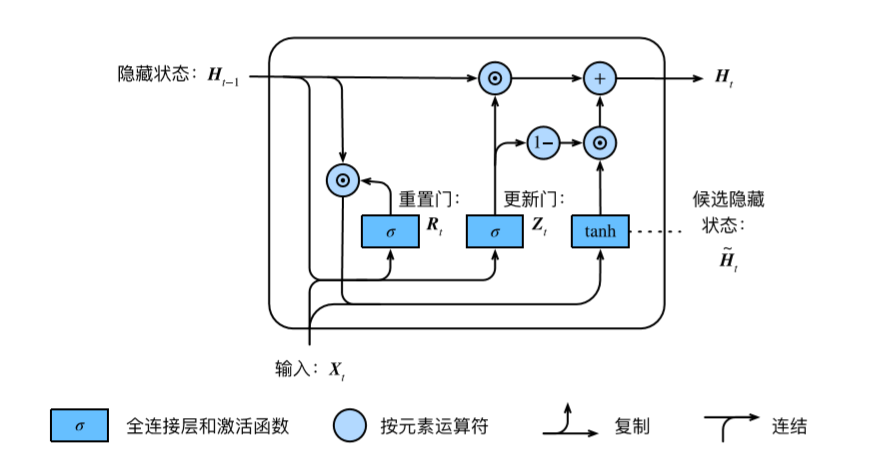

In [1]:
import os
os.listdir('/home/kesci/input')

['d2lzh1981', 'houseprices2807', 'jaychou_lyrics4703', 'd2l_jay9460']

In [3]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F



In [4]:
import sys
sys.path.append("../input/")
import d2l_jay9460 as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()

### 初始化参数

In [5]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
print('will use', device)

def get_params():  
    def _one(shape):
        ts = torch.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=torch.float32) #正态分布
        return torch.nn.Parameter(ts, requires_grad=True)
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                torch.nn.Parameter(torch.zeros(num_hiddens, device=device, dtype=torch.float32), requires_grad=True))
     
    W_xz, W_hz, b_z = _three()  # 更新门参数
    W_xr, W_hr, b_r = _three()  # 重置门参数
    W_xh, W_hh, b_h = _three()  # 候选隐藏状态参数
    
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device, dtype=torch.float32), requires_grad=True)
    return nn.ParameterList([W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q])

def init_gru_state(batch_size, num_hiddens, device):   #隐藏状态初始化
    return (torch.zeros((batch_size, num_hiddens), device=device), )

will use cpu


### GRU模型

In [6]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, W_xz) + torch.matmul(H, W_hz) + b_z)
        R = torch.sigmoid(torch.matmul(X, W_xr) + torch.matmul(H, W_hr) + b_r)
        H_tilda = torch.tanh(torch.matmul(X, W_xh) + R * torch.matmul(H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)

### 训练模型

In [7]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

In [8]:
d2l.train_and_predict_rnn(gru, get_params, init_gru_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, False, num_epochs, num_steps, lr,
                          clipping_theta, batch_size, pred_period, pred_len,
                          prefixes)

epoch 40, perplexity 149.271885, time 1.17 sec
 - 分开 我想我不不 我想你的让我 你想我的让我 你想我不想 我想你我想想想想想你想你的可爱人  坏我的让我
 - 不分开 我想你我不想 你不我 我想你的爱爱 我想你的让我 我想你我想想想想想想你的可爱人  坏我的让我 我
epoch 160, perplexity 1.427383, time 1.16 sec
 - 分开 我已带口 你已已是不起 让你知没面对我 甩散球我满腔的怒火 我想揍你已经很久 别想躲 说你眼睛看着
 - 不分开 整过 是你开的玩笑 想通 却又再考倒我 说散 你想很久了吧? 败给你的黑色幽默 说散 你想很久了吧


### 简洁实现

In [7]:
num_hiddens=256
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率
gru_layer = nn.GRU(input_size=vocab_size, hidden_size=num_hiddens)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 1.016101, time 0.89 sec
 - 分开始想像 爸和妈当年的模样 说著一口吴侬软语的姑娘缓缓走过外滩 消失的 旧时光 一九四三 回头看 的片
 - 不分开暴风圈来不及逃 我不能再想 我不能再想 我不 我不 我不能 爱情走的太快就像龙卷风 不能承受我已无处
epoch 80, perplexity 1.010881, time 0.96 sec
 - 分开都会值得去做 我想大声宣布 对你依依不舍 连隔壁邻居都猜到我现在的感受 河边的风 在吹着头发飘动 牵
 - 不分开暴风圈来不及逃 我不能再想 我不能再想 我不 我不 我不能 爱情走的太快就像龙卷风 不能承受我已无处
epoch 120, perplexity 1.011403, time 0.95 sec
 - 分开的我爱你看棒球 想这样没担忧 唱着歌 一直走 我想就这样牵着你的手不放开 爱可不可以简简单单没有伤害
 - 不分开暴风圈来不及逃 我不能再想 我不能再想 我不 我不 我不能 爱情走的太快就像龙卷风 不能承受我已无处
epoch 160, perplexity 1.058085, time 0.88 sec
 - 分开始打呼 管到当初爱你的时空 停格内容不忠 所有回忆对着我进攻   简单爱情来的太快就像龙卷风 离不开
 - 不分开始打呼 管家是一只是我怕眼泪撑不住 不懂 你给我抬起头 有话去对医药箱说 别怪我 别怪我 说你怎么面


# LSTM

** 长短期记忆long short-term memory **:  
遗忘门:控制上一时间步的记忆细胞 
输入门:控制当前时间步的输入  
输出门:控制从记忆细胞到隐藏状态  
记忆细胞：⼀种特殊的隐藏状态的信息的流动  


![Image Name](https://cdn.kesci.com/upload/image/q5jk2bnnej.png?imageView2/0/w/640/h/640)

$$
I_t = σ(X_tW_{xi} + H_{t−1}W_{hi} + b_i) \\
F_t = σ(X_tW_{xf} + H_{t−1}W_{hf} + b_f)\\
O_t = σ(X_tW_{xo} + H_{t−1}W_{ho} + b_o)\\
\widetilde{C}_t = tanh(X_tW_{xc} + H_{t−1}W_{hc} + b_c)\\
C_t = F_t ⊙C_{t−1} + I_t ⊙\widetilde{C}_t\\
H_t = O_t⊙tanh(C_t)
$$

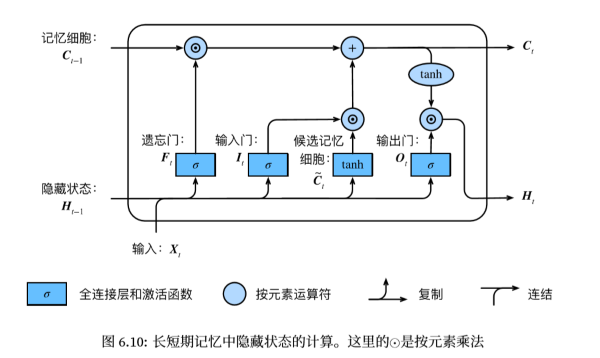

### 初始化参数

In [10]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
print('will use', device)

def get_params():
    def _one(shape):
        ts = torch.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=torch.float32)
        return torch.nn.Parameter(ts, requires_grad=True)
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                torch.nn.Parameter(torch.zeros(num_hiddens, device=device, dtype=torch.float32), requires_grad=True))
    
    W_xi, W_hi, b_i = _three()  # 输入门参数
    W_xf, W_hf, b_f = _three()  # 遗忘门参数
    W_xo, W_ho, b_o = _three()  # 输出门参数
    W_xc, W_hc, b_c = _three()  # 候选记忆细胞参数
    
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device, dtype=torch.float32), requires_grad=True)
    return nn.ParameterList([W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q])

def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), 
            torch.zeros((batch_size, num_hiddens), device=device))

will use cpu


### LSTM模型

In [11]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, W_xi) + torch.matmul(H, W_hi) + b_i)
        F = torch.sigmoid(torch.matmul(X, W_xf) + torch.matmul(H, W_hf) + b_f)
        O = torch.sigmoid(torch.matmul(X, W_xo) + torch.matmul(H, W_ho) + b_o)
        C_tilda = torch.tanh(torch.matmul(X, W_xc) + torch.matmul(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * C.tanh()
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H, C)

### 训练模型

In [12]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

d2l.train_and_predict_rnn(lstm, get_params, init_lstm_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, False, num_epochs, num_steps, lr,
                          clipping_theta, batch_size, pred_period, pred_len,
                          prefixes)

epoch 40, perplexity 211.457328, time 1.51 sec
 - 分开 我不的我 我不的我 我不不 我不的我 我不不 我不的我 我不不 我不的我 我不不 我不的我 我不不
 - 不分开 我不不 我不的我 我不不 我不的我 我不不 我不的我 我不不 我不的我 我不不 我不的我 我不不 
epoch 80, perplexity 68.458662, time 1.50 sec
 - 分开 我想你这你 我不要这你 我不要这你 我不要这你 我不要这你 我不要这你 我不要这你 我不要这你 我
 - 不分开 我想你你的你 我想要你 我不要 我不要 我不要 我不要 我不要 我不要 我不要 我不要 我不要 我
epoch 120, perplexity 15.034657, time 1.49 sec
 - 分开 我想你你的你笑 不知不觉 你你了一我不我 别发抖 快给我抬起起着你 别发抖 快给我抬起头 有你去对
 - 不分开 我想你你 我不要再想我 不知不觉 你你了离不我 不知不觉 你跟了离不我 不知不觉 我该了这节活 后
epoch 160, perplexity 3.897414, time 1.49 sec
 - 分开 我想带你里嵩山 学少林跟了了刚 我想就你了嵩着 我想去这生嵩 不天到双截棍 哼哼哈兮 快使用双截棍
 - 不分开 我 我你你的微笑 像通  又又我 我想就这样牵着你的手不放  穿过来回单单 我 想和你样堡堡 我想


### 简洁实现

In [13]:
num_hiddens=256
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率
lstm_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens)
model = d2l.RNNModel(lstm_layer, vocab_size)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 1.019881, time 1.04 sec
 - 分开始打呼 管家是一只会说法语举止优雅的猪 吸血前会念约翰福音做为弥补 拥有一双蓝色眼睛的凯萨琳公主 专
 - 不分开的玩笑 想通 却又再考倒我 说散 你想很久了吧? 败给你的黑色幽默 不想太多 我想一定是我听错弄错搞
epoch 80, perplexity 1.013078, time 1.01 sec
 - 分开的话像语言暴力 我已无能为力再提起 决定中断熟悉 然后在这里 不限日期 然后将过去 慢慢温习 让我爱
 - 不分开的玩笑 想通 却又再考倒我 说散 你想很久了吧? 败给你的黑色幽默 说散 你想很久了吧? 我的认真败
epoch 120, perplexity 1.010264, time 1.01 sec
 - 分开 我们儿子她人在江南等我 泪不休 语沉默 一壶好酒 再来一碗热粥 配上几斤的牛肉 我说店小二 三两银
 - 不分开 我有你看棒球 想这样没担忧 唱着歌 一直走 我想就这样牵着你的手不放开 爱可不可以简简单单没有伤害
epoch 160, perplexity 1.008950, time 1.02 sec
 - 分开 我才  原来我只想要你 陪我去吃汉堡  说穿了其实我的愿望就怎么小 就怎么每天祈祷我的心跳你知道 
 - 不分开 我才你看 我想要再这样打我妈妈 我说的话 你甘会听 不要再这样打我妈妈 难道你手不会痛吗 其实我回


# 深度循环神经网络  

![Image Name](https://cdn.kesci.com/upload/image/q5jk3z1hvz.png?imageView2/0/w/320/h/320)


$$
\boldsymbol{H}_t^{(1)} = \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh}^{(1)} + \boldsymbol{H}_{t-1}^{(1)} \boldsymbol{W}_{hh}^{(1)} + \boldsymbol{b}_h^{(1)})\\
\boldsymbol{H}_t^{(\ell)} = \phi(\boldsymbol{H}_t^{(\ell-1)} \boldsymbol{W}_{xh}^{(\ell)} + \boldsymbol{H}_{t-1}^{(\ell)} \boldsymbol{W}_{hh}^{(\ell)} + \boldsymbol{b}_h^{(\ell)})\\
\boldsymbol{O}_t = \boldsymbol{H}_t^{(L)} \boldsymbol{W}_{hq} + \boldsymbol{b}_q
$$
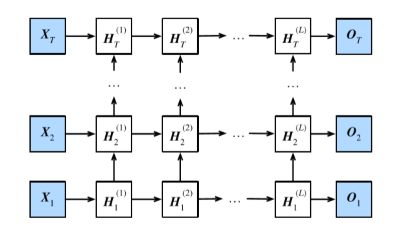

In [14]:


num_hiddens=256
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率

gru_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens,num_layers=2)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 12.840496, time 1.52 sec
 - 分开我 想你的话我在想再你的让我女疼 我想你 我有要有 想你你 想你的让我女沉 我想你你 想你的让我女沉
 - 不分开的经爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我
epoch 80, perplexity 1.247634, time 1.52 sec
 - 分开有一条热昏头的响尾蛇 无力的躺在干枯的河 在等待雨季来临变沼泽 灰狼啃食著水鹿的骨头 秃鹰盘旋死盯着
 - 不分开的会手 穿梭放受 一朵一朵因你而香 试图让夕阳飞翔 带领你我环绕大自然 迎著风 开始共渡每一天 手牵
epoch 120, perplexity 1.021974, time 1.56 sec
 - 分开我妈妈 我有多重要 我后悔没让你知道 安静的听你撒娇 看你睡著一直到老 就是开不了口让她知道 就是那
 - 不分开的会堡  想要将我不投 又不会掩护我 选你这种队友 瞎透了我 说你说 分数怎么停留 一直在停留 谁让
epoch 160, perplexity 1.016324, time 1.59 sec
 - 分开在没有一个人身留  旧时光 一九四三 在回忆 的路上 时间变好慢 老街坊 小弄堂 是属于那年代白墙黑
 - 不分开的我有 有样的要再这样打我妈妈 难道你手不会痛吗 不要再这样打我妈妈 难道你手不会痛吗 不要再这样打


In [15]:
gru_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens,num_layers=6)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 276.815235, time 8.50 sec
 - 分开                                                  
 - 不分开                                                  
epoch 80, perplexity 276.278550, time 8.51 sec
 - 分开                                                  
 - 不分开                                                  
epoch 120, perplexity 276.146710, time 8.53 sec
 - 分开                                                  
 - 不分开                                                  
epoch 160, perplexity 275.739864, time 9.04 sec
 - 分开                                                  
 - 不分开                                                  


# 双向循环神经网络 

![Image Name](https://cdn.kesci.com/upload/image/q5j8hmgyrz.png?imageView2/0/w/320/h/320)

$$ 
\begin{aligned} \overrightarrow{\boldsymbol{H}}_t &= \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh}^{(f)} + \overrightarrow{\boldsymbol{H}}_{t-1} \boldsymbol{W}_{hh}^{(f)} + \boldsymbol{b}_h^{(f)})\\
\overleftarrow{\boldsymbol{H}}_t &= \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh}^{(b)} + \overleftarrow{\boldsymbol{H}}_{t+1} \boldsymbol{W}_{hh}^{(b)} + \boldsymbol{b}_h^{(b)}) \end{aligned} $$
$$
\boldsymbol{H}_t=(\overrightarrow{\boldsymbol{H}}_{t}, \overleftarrow{\boldsymbol{H}}_t)
$$
$$
\boldsymbol{O}_t = \boldsymbol{H}_t \boldsymbol{W}_{hq} + \boldsymbol{b}_q
$$
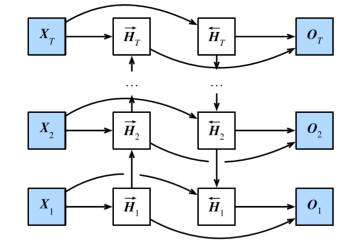

In [16]:
num_hiddens=128
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e-2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率

gru_layer = nn.GRU(input_size=vocab_size, hidden_size=num_hiddens,bidirectional=True)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 1.001741, time 0.91 sec
 - 分开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开
 - 不分开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开
epoch 80, perplexity 1.000520, time 0.91 sec
 - 分开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开
 - 不分开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开
epoch 120, perplexity 1.000255, time 0.99 sec
 - 分开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开
 - 不分开球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我
epoch 160, perplexity 1.000151, time 0.92 sec
 - 分开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开始开
 - 不分开球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我球我
